# Credit Card Fraud Detection




## 1. Setup

Installing the required packages.

In [17]:
import sys
!{sys.executable} -m pip install --quiet scikit-learn pandas matplotlib seaborn imbalanced-learn xgboost

## 2. Load Data

Load the dataset and show basic shape and class distribution.

In [18]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Data_Projects/Data/creditcard.csv')
print('Shape:', df.shape)
print('\nClass counts:')
print(df['Class'].value_counts())
print('\nClass distribution (%):')
print(df['Class'].value_counts(normalize=True) * 100)

Shape: (284807, 31)

Class counts:
Class
0    284315
1       492
Name: count, dtype: int64

Class distribution (%):
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


## 3. Missing Values and Basic Stats

Check for missing values and show statistics for `Amount` and `Time`.

In [6]:
print('Missing values per column:')
print(df.isnull().sum())
print('\nAmount and Time statistics:')
print(df[['Amount','Time']].describe())

Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Amount and Time statistics:
              Amount           Time
count  284807.000000  284807.000000
mean       88.349619   94813.859575
std       250.120109   47488.145955
min         0.000000       0.000000
25%         5.600000   54201.500000
50%        22.000000   84692.000000
75%        77.165000  139320.500000
max     25691.160000  172792.000000


## 4. Exploratory Data Analysis (EDA)

Plot overall amount distribution and fraud vs legit amount distribution.

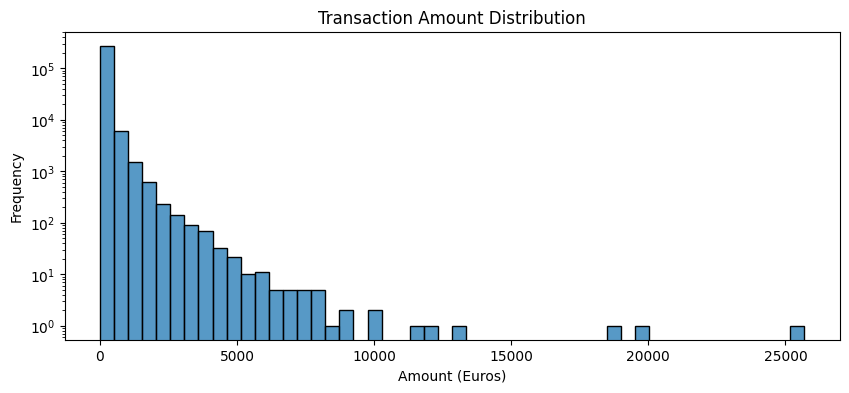

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.histplot(df['Amount'], bins=50)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount (Euros)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

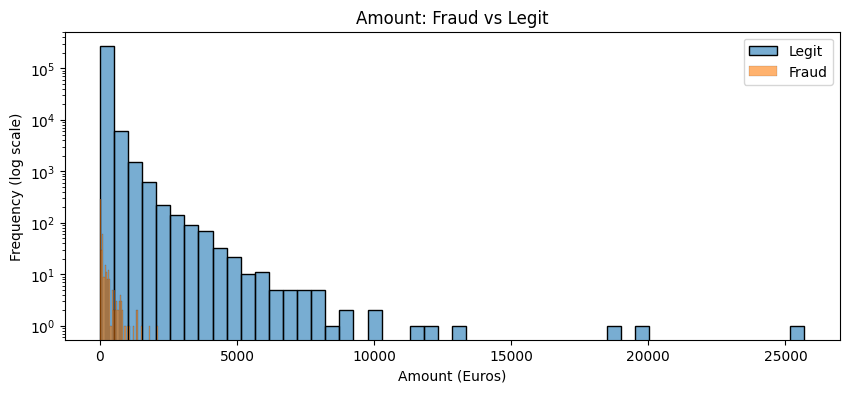

In [8]:
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

plt.figure(figsize=(10,4))
sns.histplot(legit['Amount'], bins=50, label='Legit', alpha=0.6)
sns.histplot(fraud['Amount'], bins=50, label='Fraud', alpha=0.6)
plt.title('Amount: Fraud vs Legit')
plt.xlabel('Amount (Euros)')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

## 5. Time Analysis

Convert `Time` (seconds since first transaction) to hour of day and plot hourly distribution for fraud vs legit.

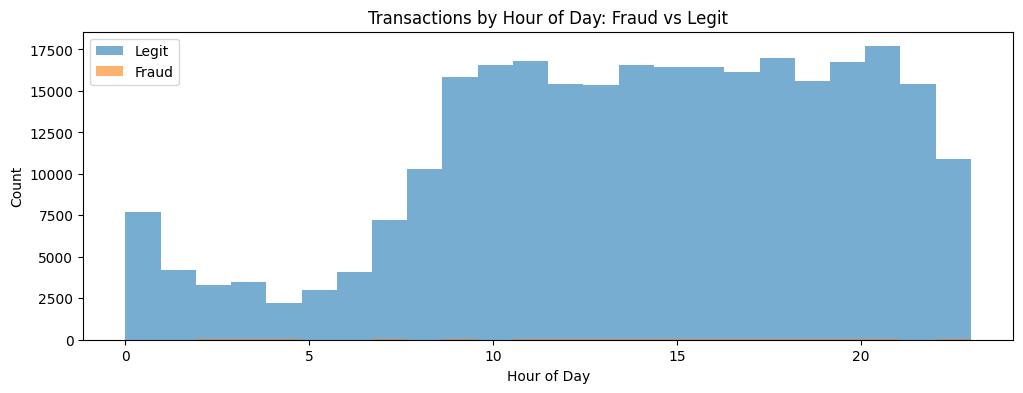

In [10]:
df['Hour'] = (df['Time'] // 3600) % 24

fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

plt.figure(figsize=(12,4))
plt.hist(legit['Hour'], bins=24, alpha=0.6, label='Legit')
plt.hist(fraud['Hour'], bins=24, alpha=0.6, label='Fraud')
plt.title('Transactions by Hour of Day: Fraud vs Legit')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend()
plt.show()

## 6. Preprocessing

Scale `Time` and `Amount`. Prepare features and labels.

In [11]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class'])
y = df['Class'].values

scaler = StandardScaler()
X[['Time','Amount']] = scaler.fit_transform(X[['Time','Amount']])

print('Feature shape:', X.shape)
print('Label shape:', y.shape)

Feature shape: (284807, 31)
Label shape: (284807,)


## 7. Train / Test Split

Here I just create a stratified split to keep class proportions.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (227845, 31)
Test shape: (56962, 31)


## 8. Baseline Model: Logistic Regression



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, classification_report

lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr.fit(X_train, y_train)

y_prob_lr = lr.predict_proba(X_test)[:,1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

print('Logistic Regression PR AUC:', round(pr_auc_lr, 4))
print('\nClassification report (threshold 0.5):')
print(classification_report(y_test, lr.predict(X_test)))

Logistic Regression PR AUC: 0.7692

Classification report (threshold 0.5):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962



## 9. Tree Model: Random Forest




In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:,1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

print('Random Forest PR AUC:', round(pr_auc_rf, 4))
print('\nClassification report (threshold 0.5):')
print(classification_report(y_test, rf.predict(X_test)))

Random Forest PR AUC: 0.8703

Classification report (threshold 0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## 10. Handling Imbalance: SMOTE + XGBoost


In [15]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

xgb_clf = xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)
xgb_clf.fit(X_res, y_res)

y_prob_xgb = xgb_clf.predict_proba(X_test)[:,1]
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

print('XGBoost (SMOTE) PR AUC:', round(pr_auc_xgb, 4))
print('\nClassification report (threshold 0.5):')
print(classification_report(y_test, xgb_clf.predict(X_test)))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:27:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (SMOTE) PR AUC: 0.8761

Classification report (threshold 0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.86      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962



## 11. Results Summary

Show the Model with the best results

In [16]:
results = {'Logistic Regression': pr_auc_lr, 'Random Forest': pr_auc_rf, 'XGBoost (SMOTE)': pr_auc_xgb}
for k,v in results.items():
    print(k, 'PR AUC =', round(v,4))

Logistic Regression PR AUC = 0.7692
Random Forest PR AUC = 0.8703
XGBoost (SMOTE) PR AUC = 0.8761


Final Thoughts: The evaluation results show that Logistic Regression achieved a PR AUC of 0.7692, while the Random Forest improved performance to 0.8703. The best results came from XGBoost with SMOTE oversampling, reaching a PR AUC of 0.8761